In [1]:
!pip install keras

In [2]:
import numpy as np
from numpy import expand_dims
import pandas as pd
import json
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import keras
from keras import layers
from scikeras.wrappers import KerasClassifier

#from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.src.legacy.preprocessing.image import ImageDataGenerator


#from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [3]:
with open('C:/Users/krish/OneDrive/Documents/GitHub/KaleidEO/archive/shipsnet.json') as data_file:
    dataset = json.load(data_file)
shipsnet= pd.DataFrame(dataset)
shipsnet.head(1000)

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007
...,...,...,...,...
995,"[103, 95, 99, 108, 110, 125, 131, 125, 133, 13...",1,"[-122.34862085843947, 37.767167357603554]",20170921_181406_1031
996,"[75, 75, 75, 75, 74, 70, 69, 72, 73, 72, 70, 6...",1,"[-122.33786604607423, 37.73944613318674]",20170604_180820_0f52
997,"[75, 74, 75, 75, 74, 74, 75, 76, 76, 75, 75, 7...",1,"[-122.33284969739871, 37.71792145705744]",20170721_180825_100b
998,"[49, 50, 49, 45, 49, 53, 52, 46, 43, 44, 49, 5...",1,"[-122.35668820008198, 37.75991104734941]",20170618_180801_0f34


In [4]:
print(len(shipsnet['data'][0]))

19200


In [5]:
shipsnet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       4000 non-null   object
 1   labels     4000 non-null   int64 
 2   locations  4000 non-null   object
 3   scene_ids  4000 non-null   object
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


In [6]:
shipsnet = shipsnet[["data","labels"]]
shipsnet.head()

,data,labels
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1


In [7]:
ship_images = shipsnet["labels"].value_counts()[0]
no_ship_images = shipsnet["labels"].value_counts()[1]
print("Number of the ship_images :{}".format(ship_images),"\n")
print("Number of the ship_images :{}".format(no_ship_images))

Number of the ship_images :3000 

Number of the ship_images :1000


In [8]:
# Turning the json information into numpy array and then assign it as x and y variables
x = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')

In [9]:
x.shape

(4000, 19200)

In [10]:
x

array([[ 82,  89,  91, ...,  86,  88,  89],
       [ 76,  75,  67, ...,  54,  57,  58],
       [125, 127, 129, ..., 111, 109, 115],
       ...,
       [171, 135, 118, ...,  95,  95,  85],
       [ 85,  90,  94, ...,  96,  95,  89],
       [122, 122, 126, ...,  51,  46,  69]], dtype=uint8)

In [11]:
x_reshaped = x.reshape([-1, 3, 80, 80])

In [12]:
x_reshaped

array([[[[ 82,  89,  91, ...,  89,  84,  83],
         [ 89,  91,  89, ..., 101,  87,  87],
         [ 91,  93,  86, ...,  83,  90,  92],
         ...,
         [ 89,  88,  92, ...,  88,  85,  89],
         [ 87,  88,  91, ...,  91,  90,  90],
         [ 88,  91,  90, ...,  88,  89,  90]],

        [[ 94,  99, 101, ..., 102,  96,  96],
         [100, 102, 101, ..., 115, 100,  99],
         [101, 104,  98, ...,  96, 102, 102],
         ...,
         [ 98,  98, 102, ...,  99,  97, 100],
         [ 99,  99, 101, ..., 101, 101, 102],
         [ 99, 101, 101, ..., 101, 102, 102]],

        [[ 80,  86,  89, ...,  86,  81,  84],
         [ 86,  88,  89, ...,  97,  84,  86],
         [ 88,  92,  85, ...,  81,  88,  89],
         ...,
         [ 87,  86,  89, ...,  86,  84,  87],
         [ 87,  86,  88, ...,  88,  88,  89],
         [ 85,  87,  87, ...,  86,  88,  89]]],


       [[[ 76,  75,  67, ...,  78,  77,  80],
         [ 71,  73,  72, ...,  79,  77,  81],
         [ 73,  70,  67, ..., 

In [13]:
x_reshaped[0].shape

(3, 80, 80)

In [14]:
print(x_reshaped[0][0])

[[ 82  89  91 ...  89  84  83]
 [ 89  91  89 ... 101  87  87]
 [ 91  93  86 ...  83  90  92]
 ...
 [ 89  88  92 ...  88  85  89]
 [ 87  88  91 ...  91  90  90]
 [ 88  91  90 ...  88  89  90]]


In [15]:
x_reshaped[0][0].shape

(80, 80)

In [16]:
print(x_reshaped[0][1])

[[ 94  99 101 ... 102  96  96]
 [100 102 101 ... 115 100  99]
 [101 104  98 ...  96 102 102]
 ...
 [ 98  98 102 ...  99  97 100]
 [ 99  99 101 ... 101 101 102]
 [ 99 101 101 ... 101 102 102]]


In [17]:
print(x_reshaped[0])

[[[ 82  89  91 ...  89  84  83]
  [ 89  91  89 ... 101  87  87]
  [ 91  93  86 ...  83  90  92]
  ...
  [ 89  88  92 ...  88  85  89]
  [ 87  88  91 ...  91  90  90]
  [ 88  91  90 ...  88  89  90]]

 [[ 94  99 101 ... 102  96  96]
  [100 102 101 ... 115 100  99]
  [101 104  98 ...  96 102 102]
  ...
  [ 98  98 102 ...  99  97 100]
  [ 99  99 101 ... 101 101 102]
  [ 99 101 101 ... 101 102 102]]

 [[ 80  86  89 ...  86  81  84]
  [ 86  88  89 ...  97  84  86]
  [ 88  92  85 ...  81  88  89]
  ...
  [ 87  86  89 ...  86  84  87]
  [ 87  86  88 ...  88  88  89]
  [ 85  87  87 ...  86  88  89]]]


In [18]:
x_reshaped[0][0].shape

(80, 80)

In [19]:
x_reshaped = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
x_reshaped.shape

(4000, 80, 80, 3)

In [20]:
print(x_reshaped[0][79])

[[ 88  99  85]
 [ 91 101  87]
 [ 90 101  87]
 [ 88 100  87]
 [ 89  99  88]
 [ 89  99  88]
 [ 86  96  84]
 [ 92 101  89]
 [ 90 100  87]
 [ 87  97  84]
 [ 86  98  84]
 [ 90 102  87]
 [ 89 100  85]
 [ 90 100  86]
 [ 89 100  86]
 [ 87  99  86]
 [ 86  99  85]
 [ 90 102  88]
 [ 90 100  86]
 [ 92 102  89]
 [ 89 100  87]
 [ 89 100  87]
 [ 89 100  88]
 [ 86  97  84]
 [ 84  95  82]
 [ 85  97  85]
 [ 90 100  90]
 [ 90 100  91]
 [ 87  98  88]
 [ 90 100  89]
 [ 86  97  86]
 [ 88  98  87]
 [ 90 101  89]
 [ 88 100  87]
 [ 85  98  85]
 [ 86 100  86]
 [ 86  99  86]
 [ 90 101  88]
 [ 91 101  89]
 [ 90  99  87]
 [ 89  97  86]
 [ 91 100  89]
 [ 90  99  88]
 [ 90 100  89]
 [ 89 100  88]
 [ 89  99  86]
 [ 92 101  87]
 [ 96 104  93]
 [ 91 100  88]
 [ 91 101  89]
 [ 89 101  87]
 [ 86  99  85]
 [ 88  99  87]
 [ 94 103  92]
 [ 93 101  90]
 [ 87  95  83]
 [ 85  95  82]
 [ 93 103  88]
 [ 99 108  93]
 [ 91 101  89]
 [ 90 101  91]
 [ 89 100  91]
 [ 89 100  90]
 [ 92 103  92]
 [ 92 103  94]
 [ 94 103  92]
 [ 91 100 

In [21]:
x_reshaped[0][4].shape

(80, 3)

In [22]:
y.shape

(4000,)

In [23]:
y_reshaped = to_categorical(y, num_classes=2)

y_reshaped.shape

(4000, 2)

In [24]:
y_reshaped

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

## Exploring the images

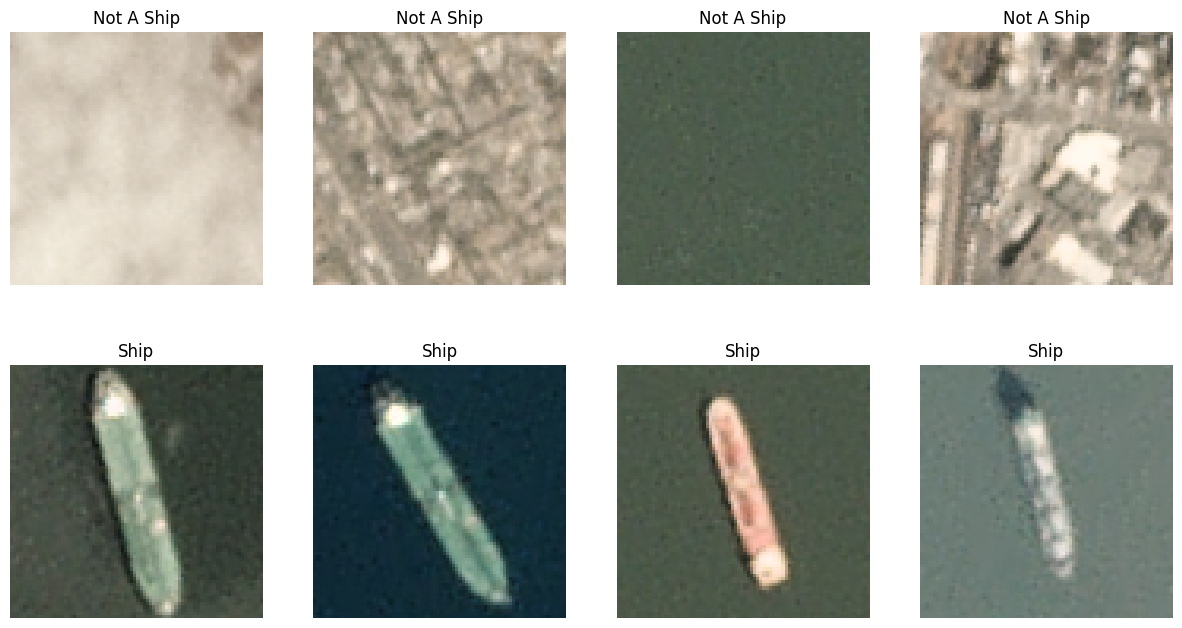

In [25]:
image_no_ship = x_reshaped[y==0]
image_ship = x_reshaped[y==1]

def plot(a,b):
    
    plt.figure(figsize=(15, 15))
    for i, k in enumerate(range(1,9)):
        if i < 4:
            plt.subplot(2,4,k)
            plt.title('Not A Ship')
            plt.imshow(image_no_ship[i+2])
            plt.axis("off")
        else:
            plt.subplot(2,4,k)
            plt.title('Ship')
            plt.imshow(image_ship[i+15])
            plt.axis("off")
            
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0.25)

#Implementation of the function 

plot(image_no_ship, image_ship)

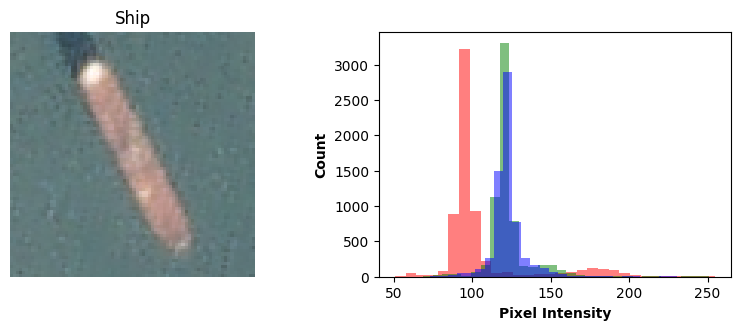

Minimum pixel value of this image: 51
Maximum pixel value of this image: 255


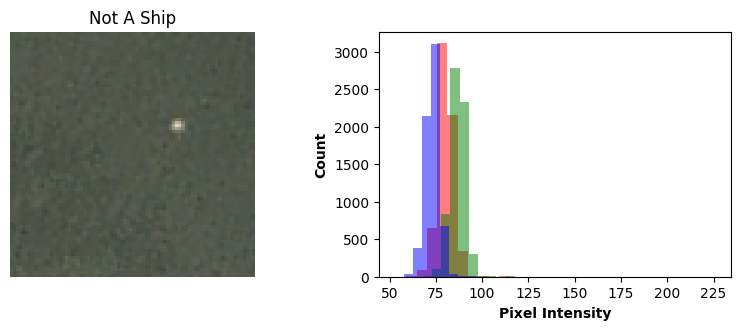

Minimum pixel value of this image: 53
Maximum pixel value of this image: 226


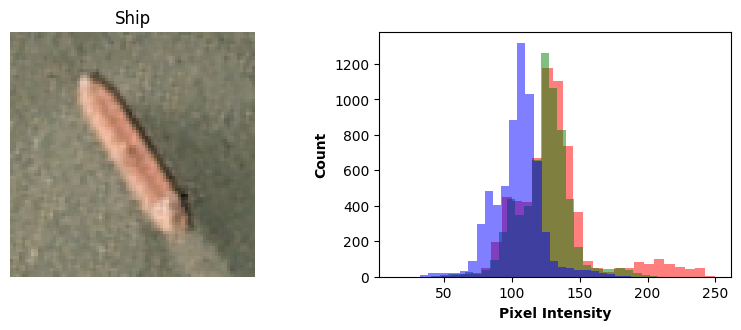

Minimum pixel value of this image: 14
Maximum pixel value of this image: 250


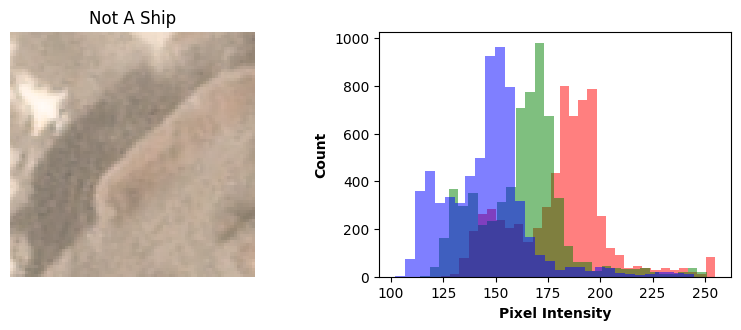

Minimum pixel value of this image: 102
Maximum pixel value of this image: 255


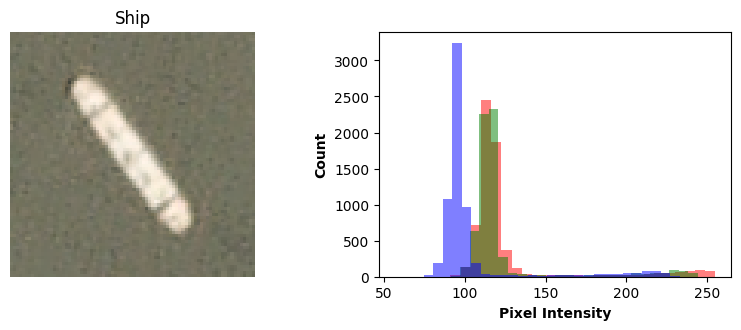

Minimum pixel value of this image: 57
Maximum pixel value of this image: 255


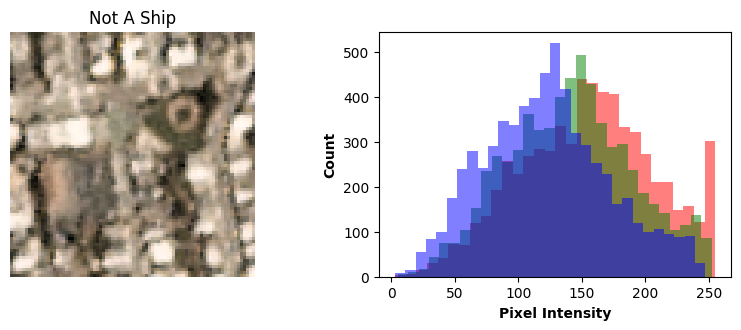

Minimum pixel value of this image: 3
Maximum pixel value of this image: 255


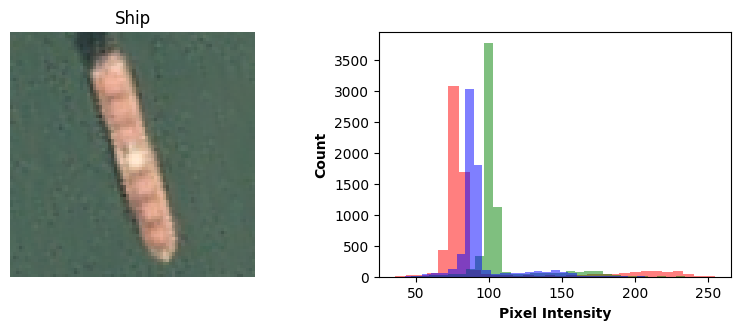

Minimum pixel value of this image: 36
Maximum pixel value of this image: 255


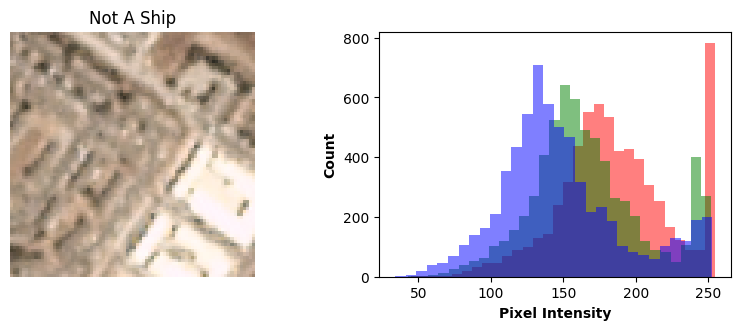

Minimum pixel value of this image: 34
Maximum pixel value of this image: 255


In [26]:
def plotHistogram(ship, not_ship):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(ship)
    plt.axis('off')
    plt.title('Ship')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(ship[:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(ship[:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(ship[:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()
    print("Minimum pixel value of this image: {}".format(ship.min()))
    print("Maximum pixel value of this image: {}".format(ship.max()))
    plt.figure(figsize = (10,7))
    plt.subplot(2,2,3)
    plt.imshow(not_ship)
    plt.axis('off')
    plt.title('Not A Ship')
    histo = plt.subplot(2,2,4)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(not_ship[:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(not_ship[:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(not_ship[:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()
    print("Minimum pixel value of this image: {}".format(not_ship.min()))
    print("Maximum pixel value of this image: {}".format(not_ship.max()))
#Implementation of the function

for i in range (10,14):
    plotHistogram(x_reshaped[y==1][i], x_reshaped[y==0][i])

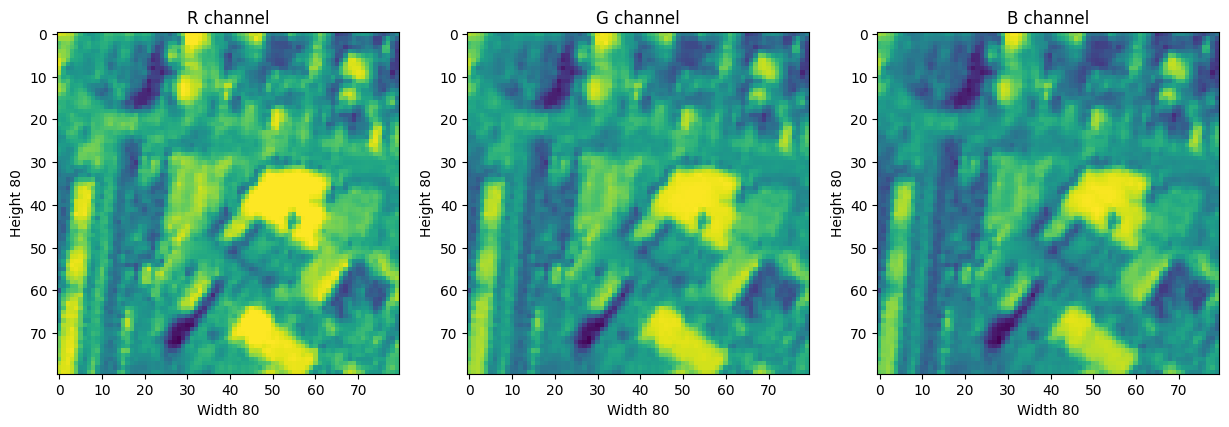

In [27]:
my_list = [(0, 'R channel'), (1, 'G channel'), (2, 'B channel')]

plt.figure(figsize = (15,15))

for i, k in my_list:
    plt.subplot(1,3,i+1)
    plt.title(k)
    plt.ylabel('Height {}'.format(x_reshaped[y==0][5].shape[0]))
    plt.xlabel('Width {}'.format(x_reshaped[y==0][5].shape[1]))
    plt.imshow(x_reshaped[y==0][5][ : , : , i])

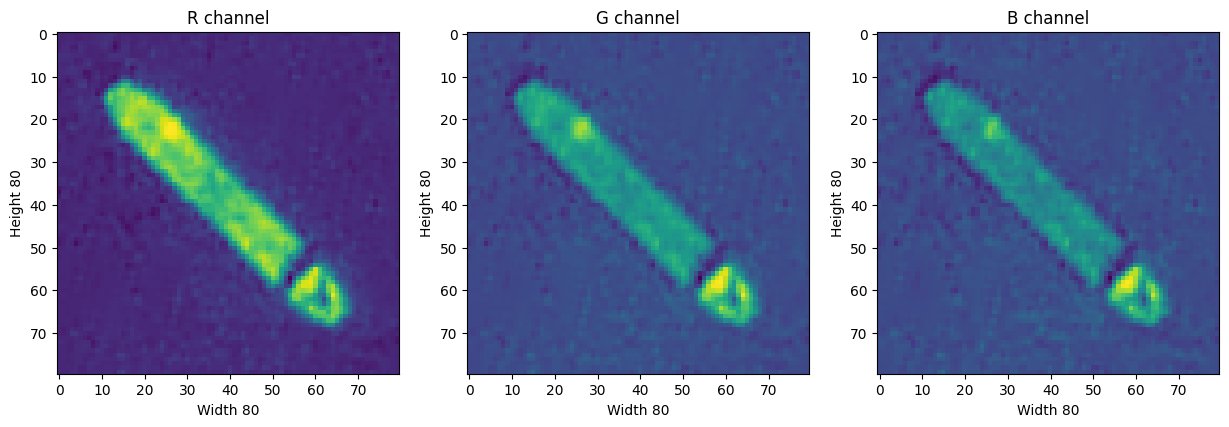

In [28]:
my_list = [(0, 'R channel'), (1, 'G channel'), (2, 'B channel')]

plt.figure(figsize = (15,15))

for i, k in my_list:
    plt.subplot(1,3,i+1)
    plt.title(k)
    plt.ylabel('Height {}'.format(x_reshaped[y==0][5].shape[0]))
    plt.xlabel('Width {}'.format(x_reshaped[y==0][5].shape[1]))
    plt.imshow(x_reshaped[y==1][5][ : , : , i])

## Modelling

In [29]:
x_reshaped = x_reshaped / 255

In [30]:
x_reshaped[0][0][0] # Normalized RGB values of the firs pixel of the first image in the dataset.

array([0.32156863, 0.36862745, 0.31372549])

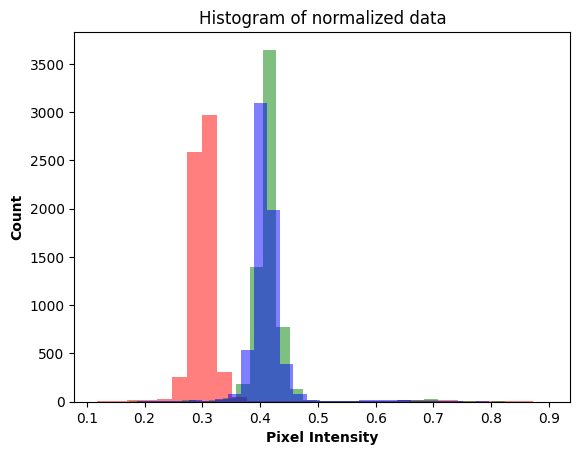

In [31]:
n_bins = 30
plt.hist(x_reshaped[y == 0][0][:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
plt.hist(x_reshaped[y == 0][0][:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
plt.hist(x_reshaped[y == 0][0][:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
plt.ylabel('Count', fontweight = "bold")
plt.xlabel('Pixel Intensity', fontweight = "bold")
plt.title("Histogram of normalized data")
plt.show()

In [32]:
x_train_1, x_test, y_train_1, y_test = train_test_split(x_reshaped, y_reshaped,
                                                        test_size = 0.20, random_state = 42)


x_train, x_val, y_train, y_val = train_test_split(x_train_1, y_train_1, 
                                                  test_size = 0.25, random_state = 42)


print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)
print("y_train shape",x_val.shape)
print("y_test shape",y_val.shape)
print("x_train_1 shape",x_train_1.shape)
print("x_val shape",x_val.shape)
print("y_train_1 shape",y_train_1.shape)



x_train shape (2400, 80, 80, 3)
x_test shape (800, 80, 80, 3)
y_train shape (2400, 2)
y_test shape (800, 2)
y_train shape (800, 80, 80, 3)
y_test shape (800, 2)
x_train_1 shape (3200, 80, 80, 3)
x_val shape (800, 80, 80, 3)
y_train_1 shape (3200, 2)


In [33]:
x_test.shape

(800, 80, 80, 3)

In [34]:
x_train.shape

(2400, 80, 80, 3)

## ANN 

In [35]:
from keras import callbacks
model = Sequential()
model.add(Flatten(input_shape=[80, 80, 3]))
model.add(Dense(200, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

history = model.fit(x_train, y_train, epochs = 100, validation_data=(x_val, y_val), callbacks = [earlystopping])

c:\Users\krish\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.6878 - loss: 2.1895 - val_accuracy: 0.8225 - val_loss: 0.4795
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7904 - loss: 0.5430 - val_accuracy: 0.8737 - val_loss: 0.3490
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8689 - loss: 0.3145 - val_accuracy: 0.8850 - val_loss: 0.3151
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8768 - loss: 0.3125 - val_accuracy: 0.7075 - val_loss: 0.6647
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8601 - loss: 0.3686 - val_accuracy: 0.8950 - val_loss: 0.2723
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8886 - loss: 0.2793 - val_accuracy: 0.8562 - val_loss: 0.3128
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8917 - loss: 0.2956 - val_accuracy: 0.9050 - val_loss: 0.2517
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8916 - loss: 0.2723 - val_accuracy: 0.

In [36]:
model.evaluate(x_test, y_test)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9166 - loss: 0.2031


[0.21862810850143433, 0.9137499928474426]

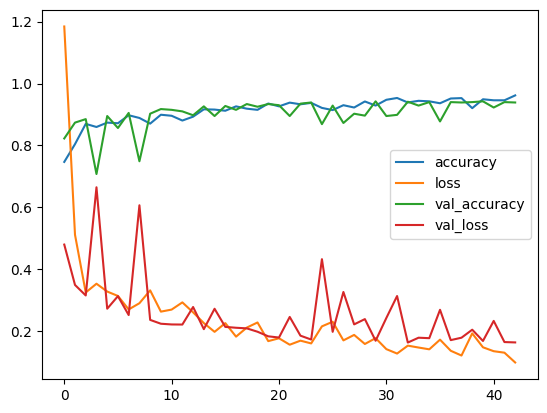

In [37]:
pd.DataFrame(history.history).plot();

In [38]:
from keras import callbacks
model = Sequential()
model.add(Flatten(input_shape=[80, 80, 3]))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

history = model.fit(x_train, y_train, epochs = 100, validation_data=(x_val, y_val), callbacks = [earlystopping])

c:\Users\krish\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6626 - loss: 1.1503 - val_accuracy: 0.8612 - val_loss: 0.3552
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8360 - loss: 0.3916 - val_accuracy: 0.8462 - val_loss: 0.3712
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8539 - loss: 0.3556 - val_accuracy: 0.8913 - val_loss: 0.3060
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8725 - loss: 0.3067 - val_accuracy: 0.8587 - val_loss: 0.3769
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8888 - loss: 0.2951 - val_accuracy: 0.8450 - val_loss: 0.4029
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8501 - loss: 0.3626 - val_accuracy: 0.8938 - val_loss: 0.2885
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9033 - loss: 0.2583 - val_accuracy: 0.8988 - val_loss: 0.2643
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9051 - loss: 0.2386 - val_accuracy: 0.

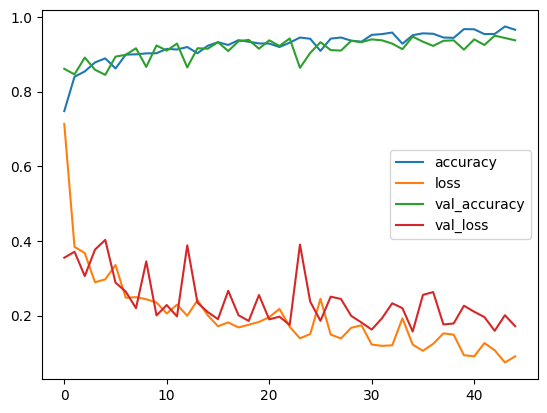

In [39]:
pd.DataFrame(history.history).plot();

In [40]:
prediction = model.predict(x_test)
pd.Series(prediction[0], index=["Not A Ship", "Ship"])

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Not A Ship    0.11712
Ship          0.88288
dtype: float32

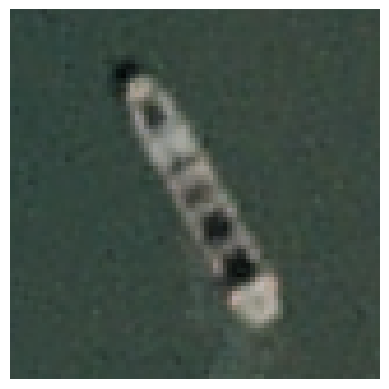

In [41]:
plt.imshow(x_test[0])
plt.axis("off")
plt.show()

In [42]:
predicted_data = pd.DataFrame(prediction, columns=["Not A Ship", "Ship"])
predicted_data.head(3)

,Not A Ship,Ship
0,0.117120,0.882880
1,0.997318,0.002682
2,0.018660,0.981340


In [43]:
y_test_data = pd.DataFrame(y_test, columns=["Not A Ship", "Ship"])
y_test_data.head(3)

,Not A Ship,Ship
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0


In [44]:
predicted_data['There is a Ship'] = y_test[:, 1]
predicted_data.head()

,Not A Ship,Ship,There is a Ship
0,0.117120,8.828803e-01,1.0
1,0.997318,2.682099e-03,0.0
2,0.018660,9.813398e-01,1.0
3,0.007823,9.921772e-01,0.0
4,1.000000,4.220222e-07,0.0


In [45]:
predicted_data["Difference"] = predicted_data["Ship"] - predicted_data["There is a Ship"]
predicted_data

,Not A Ship,Ship,There is a Ship,Difference
0,0.117120,8.828803e-01,1.0,-1.171197e-01
1,0.997318,2.682099e-03,0.0,2.682099e-03
2,0.018660,9.813398e-01,1.0,-1.866025e-02
3,0.007823,9.921772e-01,0.0,9.921772e-01
4,1.000000,4.220222e-07,0.0,4.220222e-07
...,...,...,...,...
795,0.469739,5.302607e-01,0.0,5.302607e-01
796,0.284774,7.152261e-01,1.0,-2.847739e-01
797,0.997768,2.232292e-03,0.0,2.232292e-03
798,0.999479,5.207738e-04,0.0,5.207738e-04


In [46]:
predicted_data.sort_values('Difference', ascending=False).head(10)

,Not A Ship,Ship,There is a Ship,Difference
528,0.000469,0.999531,0.0,0.999531
628,0.002694,0.997306,0.0,0.997306
3,0.007823,0.992177,0.0,0.992177
413,0.007946,0.992054,0.0,0.992054
771,0.019499,0.980501,0.0,0.980501
657,0.021636,0.978364,0.0,0.978364
783,0.027823,0.972177,0.0,0.972177
717,0.048504,0.951496,0.0,0.951496
484,0.112910,0.887090,0.0,0.887090
14,0.132456,0.867544,0.0,0.867544


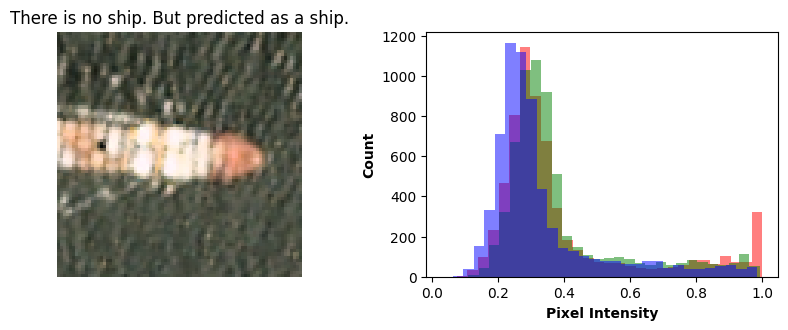

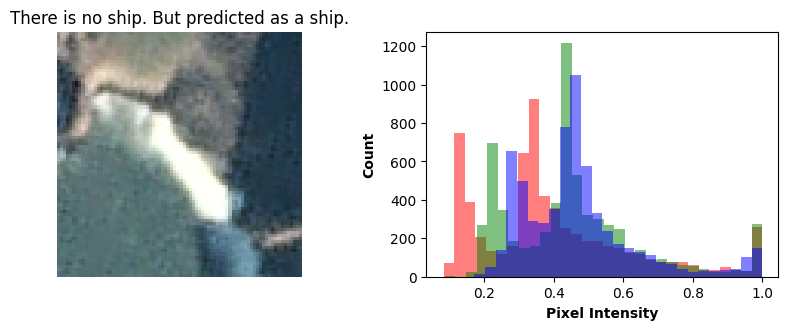

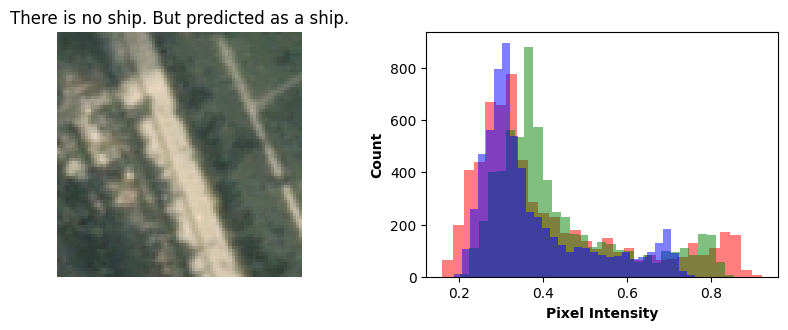

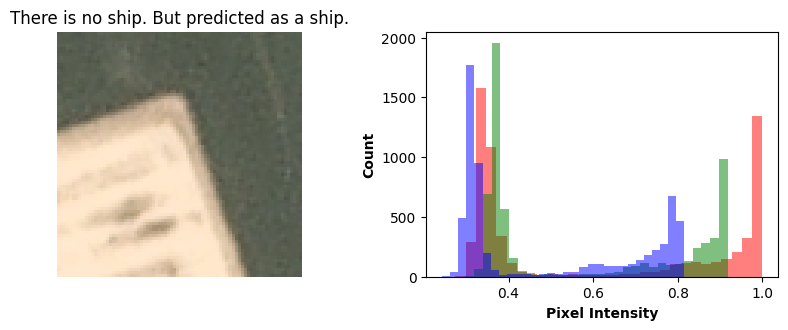

In [47]:
indexes = predicted_data.sort_values('Difference', ascending = False).head(4).index.to_list()

def plotHistogram(image_index):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(x_test[image_index])
    plt.axis('off')
    plt.title('There is no ship. But predicted as a ship.')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(x_test[image_index][:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()


#Implementation of the function

for i in indexes:
    plotHistogram(i)


In [48]:
predicted_data.sort_values('Difference', ascending=True).head(10)

,Not A Ship,Ship,There is a Ship,Difference
537,0.994071,0.005929,1.0,-0.994071
518,0.992943,0.007057,1.0,-0.992943
578,0.980397,0.019603,1.0,-0.980397
322,0.939093,0.060907,1.0,-0.939093
261,0.912789,0.087211,1.0,-0.912789
249,0.901388,0.098612,1.0,-0.901388
36,0.894272,0.105728,1.0,-0.894272
743,0.884840,0.115160,1.0,-0.884840
100,0.879714,0.120286,1.0,-0.879714
206,0.871617,0.128383,1.0,-0.871617


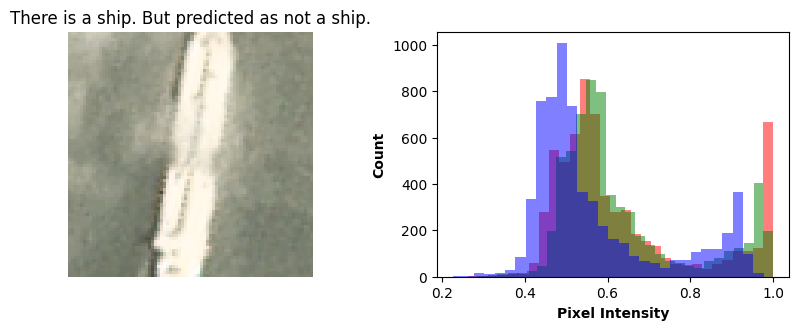

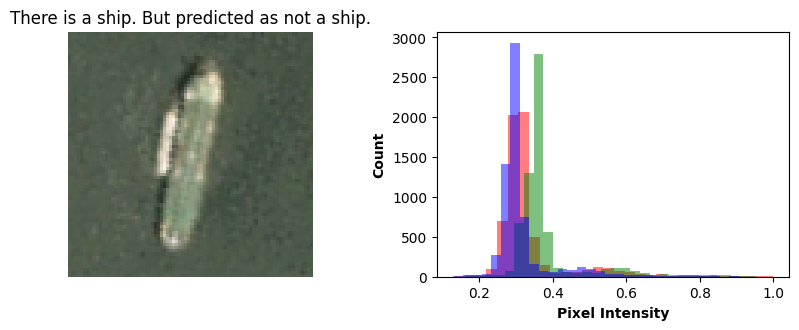

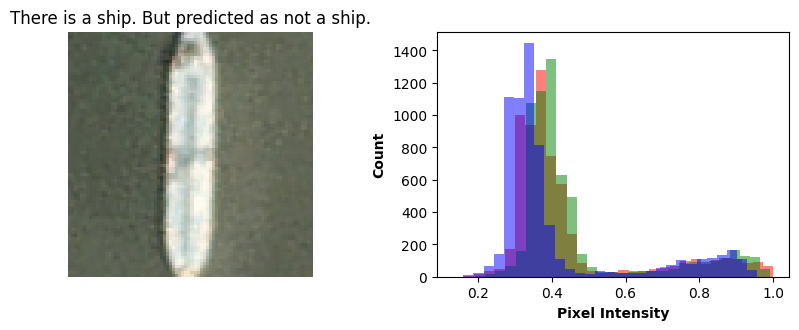

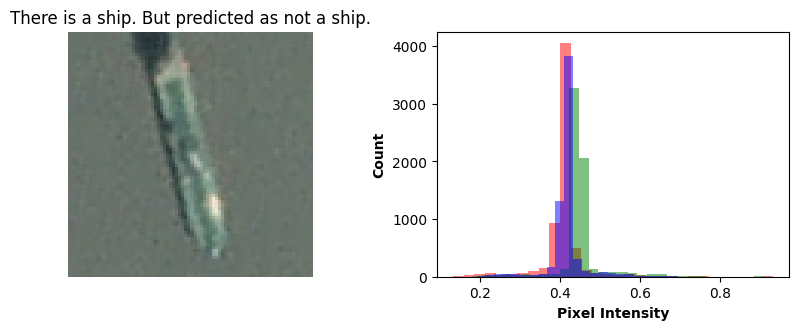

In [49]:
indexes = predicted_data.sort_values('Difference', ascending = True).head(4).index.to_list()

def plotHistogram(image_index):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(x_test[image_index])
    plt.axis('off')
    plt.title('There is a ship. But predicted as not a ship.')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(x_test[image_index][:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()

    
#Implementation of the function

for i in indexes:
    plotHistogram(i)

## CNN

In [52]:
from keras import callbacks
import tensorflow as tf
model = Sequential()
#
model.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'Same', 
                 activation ='relu', input_shape = (80,80,3)))
model.add(MaxPool2D(pool_size=(5,5)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(1,1)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(1,1)))
model.add(Dropout(0.25))

# Fully connected
model.add(Flatten())
model.add(Dense(200, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)
history = model.fit(x_train, y_train, epochs = 100, validation_data=(x_val, y_val), callbacks = [earlystopping])

c:\Users\krish\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7029 - loss: 0.6485 - val_accuracy: 0.7513 - val_loss: 0.5520
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.7603 - loss: 0.5087 - val_accuracy: 0.7513 - val_loss: 0.4460
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.7640 - loss: 0.3962 - val_accuracy: 0.9013 - val_loss: 0.3333
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.8615 - loss: 0.3071 - val_accuracy: 0.8525 - val_loss: 0.3446
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8866 - loss: 0.2909 - val_accuracy: 0.9150 - val_loss: 0.2467
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.8822 - loss: 0.2950 - val_accuracy: 0.9150 - val_loss: 0.2009
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9178 - loss: 0.2158 - val_accuracy: 0.9250 - val_loss: 0.1933
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9219 - loss: 0.2224 - val_accuracy: 0.

In [ ]:
model.evaluate(x_test, y_test)

25/25 [==============================] - 2s 66ms/step - loss: 0.0551 - accuracy: 0.9837


[0.05513330549001694, 0.9837499856948853]

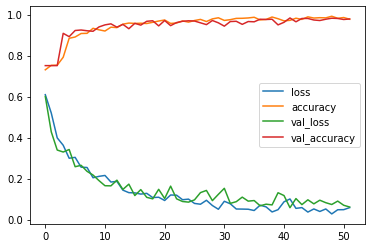

In [ ]:
pd.DataFrame(history.history).plot();


In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False,
        rotation_range=5,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False)  

datagen.fit(x_train)

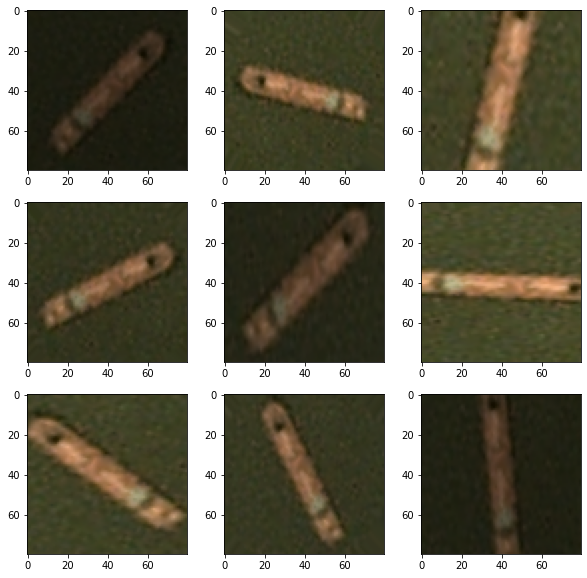

In [ ]:
data = x_reshaped[y==1][15]
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datag = ImageDataGenerator(brightness_range=[0.2,1.0],
                          zoom_range=[0.5,1.0],
                          horizontal_flip=True,
                          rotation_range=90)
# prepare iterator
it = datag.flow(samples, batch_size=1)
# generate samples and plot
plt.figure(figsize = (10,10))
for i in range(9):
    # define subplot
    plt.subplot(3,3,i+1)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
    # show the figure
plt.show()

In [ ]:
history = model.fit(datagen.flow(x_train, y_train), epochs = 100, 
                    validation_data=(x_val, y_val), callbacks = [earlystopping])

Epoch 1/100
75/75 [==============================] - 23s 300ms/step - loss: 0.1309 - accuracy: 0.9525 - val_loss: 0.1024 - val_accuracy: 0.9525
Epoch 2/100
75/75 [==============================] - 22s 299ms/step - loss: 0.1013 - accuracy: 0.9625 - val_loss: 0.0740 - val_accuracy: 0.9700
Epoch 3/100
75/75 [==============================] - 23s 300ms/step - loss: 0.1163 - accuracy: 0.9617 - val_loss: 0.0869 - val_accuracy: 0.9675
Epoch 4/100
75/75 [==============================] - 22s 298ms/step - loss: 0.0890 - accuracy: 0.9650 - val_loss: 0.0958 - val_accuracy: 0.9575
Epoch 5/100
75/75 [==============================] - 22s 299ms/step - loss: 0.1228 - accuracy: 0.9546 - val_loss: 0.0806 - val_accuracy: 0.9700
Epoch 6/100
75/75 [==============================] - 22s 299ms/step - loss: 0.0912 - accuracy: 0.9683 - val_loss: 0.0583 - val_accuracy: 0.9712
Epoch 7/100
75/75 [==============================] - 23s 300ms/step - loss: 0.0960 - accuracy: 0.9679 - val_loss: 0.0694 - val_accuracy:

In [ ]:
model.evaluate(x_test, y_test)

25/25 [==============================] - 2s 63ms/step - loss: 0.0340 - accuracy: 0.9837


[0.03399667143821716, 0.9837499856948853]


Test Accuracy Score :  0.98375 



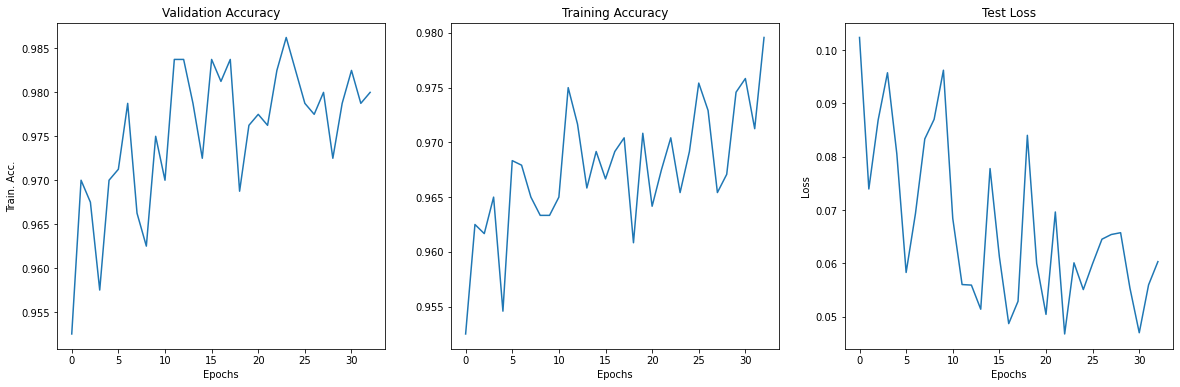

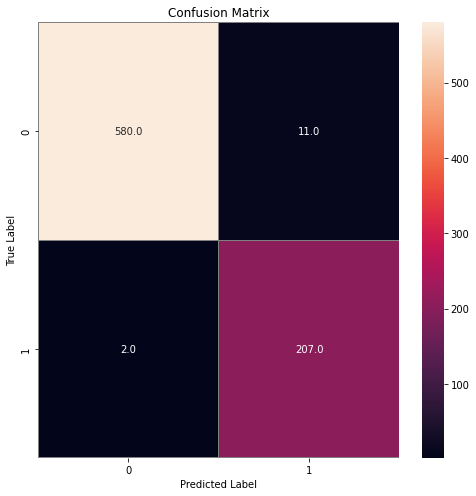

In [ ]:
from sklearn import metrics
import seaborn as sns
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# Compute the confusion matrix

print("\n""Test Accuracy Score : ",metrics.accuracy_score(Y_true, Y_pred_classes),"\n")

fig, axis = plt.subplots(1, 3, figsize=(20,6))
axis[0].plot(history.history['val_accuracy'], label='val_acc')
axis[0].set_title("Validation Accuracy")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Val. Acc.")
axis[1].plot(history.history['accuracy'], label='acc')
axis[1].set_title("Training Accuracy")
axis[1].set_xlabel("Epochs")
axis[0].set_ylabel("Train. Acc.")
axis[2].plot(history.history['val_loss'], label='val_loss')
axis[2].set_title("Test Loss")
axis[2].set_xlabel("Epochs")
axis[2].set_ylabel("Loss")

plt.show()


confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Plot the confusion matrix
f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()

plt.show()


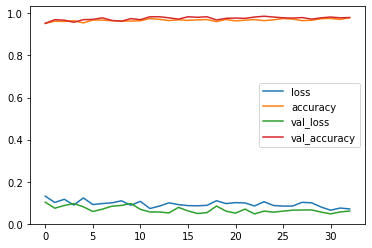

In [ ]:
pd.DataFrame(history.history).plot();

In [ ]:
prediction = model.predict(x_test)
pd.Series(prediction[0], index=["Not A Ship", "Ship"])

Not A Ship    0.020284
Ship          0.979716
dtype: float32

In [ ]:
predicted_data = pd.DataFrame(prediction, columns=["Not A Ship", "Ship"])
predicted_data.head(3)

,Not A Ship,Ship
0,0.020284,9.797157e-01
1,1.000000,1.471605e-13
2,0.005250,9.947500e-01


In [ ]:
y_test_data = pd.DataFrame(y_test, columns=["Not A Ship", "Ship"])
y_test_data.head(3)

,Not A Ship,Ship
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0


In [ ]:
predicted_data['There is a Ship'] = y_test[:, 1]
predicted_data.head()

,Not A Ship,Ship,There is a Ship
0,0.020284,9.797157e-01,1.0
1,1.000000,1.471605e-13,0.0
2,0.005250,9.947500e-01,1.0
3,0.999152,8.479123e-04,0.0
4,1.000000,1.592721e-13,0.0


In [ ]:
predicted_data["Difference"] = predicted_data["Ship"] - predicted_data["There is a Ship"]
predicted_data

,Not A Ship,Ship,There is a Ship,Difference
0,0.020284,9.797157e-01,1.0,-2.028430e-02
1,1.000000,1.471605e-13,0.0,1.471605e-13
2,0.005250,9.947500e-01,1.0,-5.250037e-03
3,0.999152,8.479123e-04,0.0,8.479123e-04
4,1.000000,1.592721e-13,0.0,1.592721e-13
...,...,...,...,...
795,0.668852,3.311477e-01,0.0,3.311477e-01
796,0.014348,9.856521e-01,1.0,-1.434791e-02
797,1.000000,1.026804e-08,0.0,1.026804e-08
798,1.000000,7.564167e-15,0.0,7.564167e-15


In [ ]:
predicted_data.sort_values('Difference', ascending=False).head(10)

,Not A Ship,Ship,There is a Ship,Difference
717,0.078492,0.921507,0.0,0.921507
699,0.094824,0.905176,0.0,0.905176
747,0.158780,0.841220,0.0,0.841220
461,0.327896,0.672104,0.0,0.672104
32,0.337117,0.662883,0.0,0.662883
217,0.385741,0.614259,0.0,0.614259
274,0.391165,0.608835,0.0,0.608835
136,0.429465,0.570535,0.0,0.570535
528,0.447985,0.552015,0.0,0.552015
564,0.459198,0.540802,0.0,0.540802


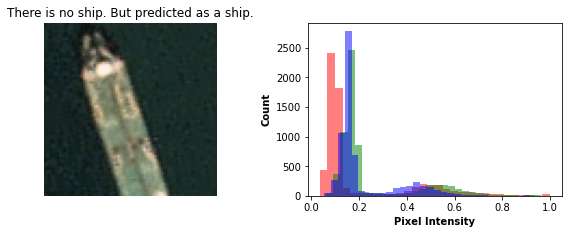

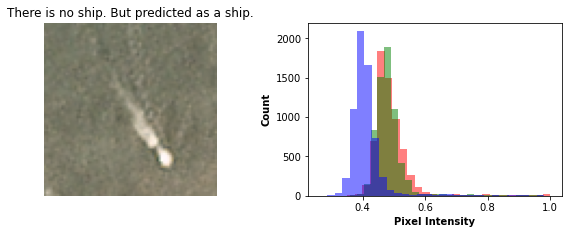

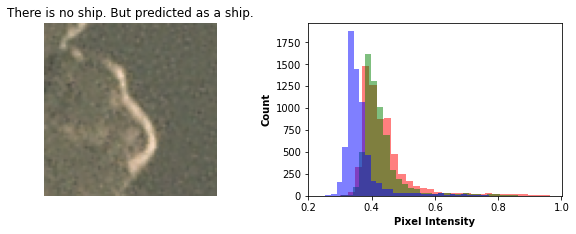

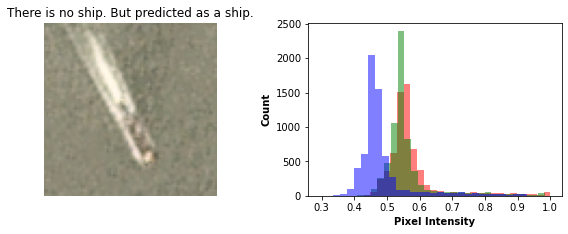

In [ ]:
indexes = predicted_data.sort_values('Difference', ascending = False).head(4).index.to_list()

def plotHistogram(image_index):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(x_test[image_index])
    plt.axis('off')
    plt.title('There is no ship. But predicted as a ship.')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(x_test[image_index][:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()


for i in indexes:
    plotHistogram(i)